In [1]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

<h2 id="cox">Cox with interaction term</h2>

In [2]:
%%R
library(survival)
library(ggfortify)
library(dplyr)

data <- filter(filter(read.csv("./cox-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3))

grp <- data[!duplicated(data$id),]
nrow(grp)
f <- Surv(start, end, event, type="counting") ~ race_factor * decile_score + age_factor + gender_factor +
                                                 priors_count + crime_factor
felonies <- c('(F1)','(F2)', '(F3)','(F5)','(F6)','(F7)')
data_filtered <-  mutate(data, crime_factor = factor(ifelse(c_charge_degree %in% felonies, 'F', 'M'))) %>%
                  mutate(age_factor = as.factor(age_cat)) %>%
                  within(age_factor <- relevel(age_factor, ref = 1)) %>%
                  mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
                  within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
                  filter(days_b_screening_arrest <= 30) %>%
                  filter(days_b_screening_arrest >= -30) %>%
                  filter(is_recid != -1)
grp <- data_filtered[!duplicated(data_filtered$id),]
print(nrow(grp))
model <- coxph(f, data=data_filtered)
print(summary(model))

[1] 8775
Call:
coxph(formula = f, data = data_filtered)

  n= 11182, number of events= 2988 

                                              coef exp(coef)  se(coef)      z
race_factorAfrican-American               0.244810  1.277378  0.088817  2.756
race_factorAsian                         -1.096574  0.334014  0.651876 -1.682
race_factorHispanic                       0.056236  1.057847  0.143650  0.391
race_factorNative American               -5.041392  0.006465  2.465844 -2.044
race_factorOther                         -0.191859  0.825423  0.167680 -1.144
decile_score                              0.163530  1.177661  0.013044 12.537
age_factorGreater than 45                -0.239126  0.787316  0.055567 -4.303
age_factorLess than 25                    0.265289  1.303807  0.046989  5.646
gender_factorFemale                      -0.400712  0.669843  0.052588 -7.620
priors_count                              0.060688  1.062567  0.003777 16.067
crime_factorM                            -0.0678

In [3]:
%%R
d <- c(1:10)
data.frame(decile_score=d, black_vs_white_hazard_ratio=exp(0.244810 - 0.042704 * d))

   decile_score black_vs_white_hazard_ratio
1             1                   1.2239777
2             2                   1.1728093
3             3                   1.1237800
4             4                   1.0768003
5             5                   1.0317847
6             6                   0.9886509
7             7                   0.9473203
8             8                   0.9077176
9             9                   0.8697704
10           10                   0.8334096


<h2 id="logistic">Logistic regression without two year recidivism term</h2>

In [4]:
%%R
raw_data <- read.csv("./compas-scores-two-years.csv")

df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')

df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0121  -0.8145  -0.3530   0.8730   2.6669  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.26216    0.07299 -17.292  < 2e-16 ***
gender_factorFemale          0.15947    0.07840   2.034 0.041955 *  
age_factorGreater than 45   -1.44095    0.09880 -14.585  < 2e-16 ***
age_factorLess than 25       1.39347    0.07461  18.678  < 2e-16 ***
race_factorAfrican-American  0.47752    0.06857   6.964 3.31e-12 ***
race_factorAsian            -0.33630    0.47811  -0.703 0.481813    
race_factorHispanic         -0.44192    0.12702  -3.479 0.000503 ***
race_factorNative American   1.25136    0.74518   1.679 0.093096 .  
race_factorOther            -0.82409    0.16043  -5.137 2.79e-07 ***
priors_count                 0.29502

In [5]:
%%R
control <- exp(-1.26216) / (1 + exp(-1.26216))
exp(0.47752) / (1 - control + (control * exp(0.47752)))

[1] 1.420297


In [6]:
%%R
library(car)
vif(model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df))

                   GVIF Df GVIF^(1/(2*Df))
gender_factor  1.030437  1        1.015104
age_factor     1.195754  2        1.045708
race_factor    1.029395  5        1.002901
priors_count   1.235550  1        1.111553
crime_factor   1.015181  1        1.007562
two_year_recid 1.046079  1        1.022780


In [7]:
%%R -w 900 -h 900 -u px
library(pROC)
raw_data <- read.csv("./compas-scores-two-years.csv")
raw_data <- mutate(raw_data, score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore")))
w <- filter(raw_data, race=="Caucasian")
wroc <- roc(two_year_recid ~ decile_score, data=w)
b <- filter(raw_data, race=="African-American")
broc <- roc(two_year_recid ~ decile_score, data=b)

<h2 id="roc-curves">Unsmoothed ROC Curves</h2>


Call:
roc.formula(formula = two_year_recid ~ decile_score, data = b)

Data: decile_score in 1795 controls (two_year_recid 0) < 1901 cases (two_year_recid 1).
Area under the curve: 0.6918


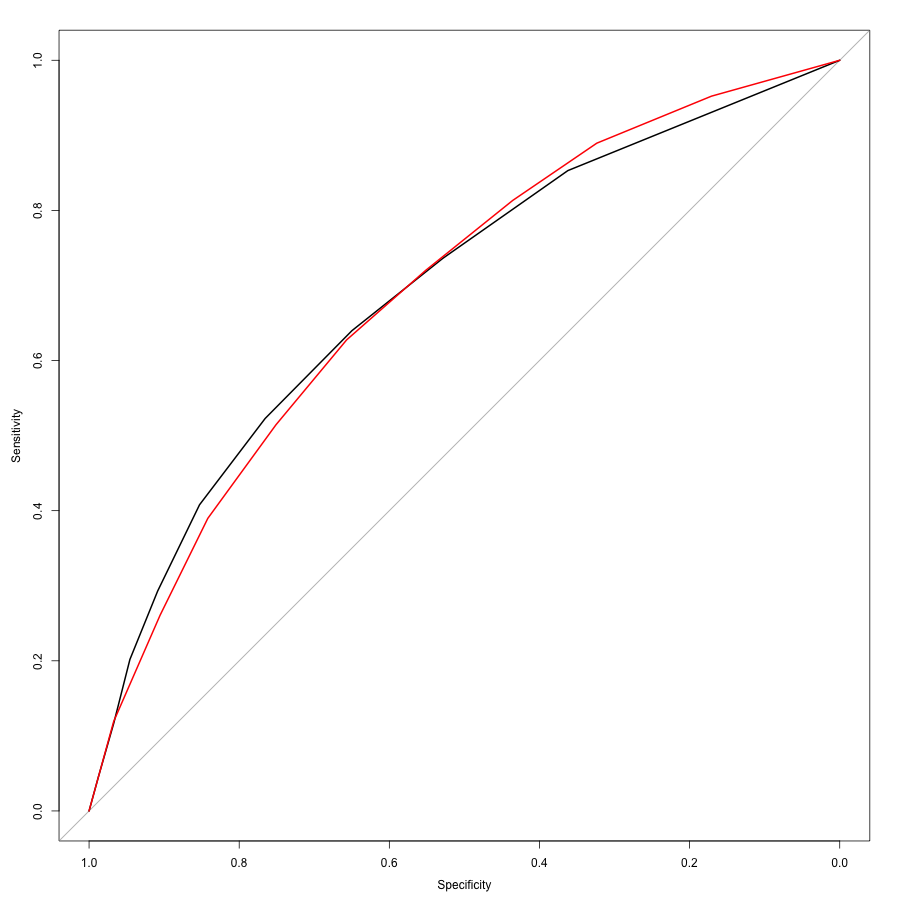

In [8]:
%%R  -w 900 -h 900 -u px
library(gridExtra)
w <- filter(raw_data, race=="Caucasian")
wroc <- roc(two_year_recid ~ decile_score, data=w)
b <- filter(raw_data, race=="African-American")
broc <- roc(two_year_recid ~ decile_score, data=b)
plot(wroc)
plot(broc, add=TRUE, col="red")


Call:
roc.formula(formula = two_year_recid ~ decile_score, data = b,     smooth = TRUE)

Data: decile_score in 1795 controls (two_year_recid 0) < 1901 cases (two_year_recid 1).
Smoothing: binormal 
Area under the curve: 0.6935


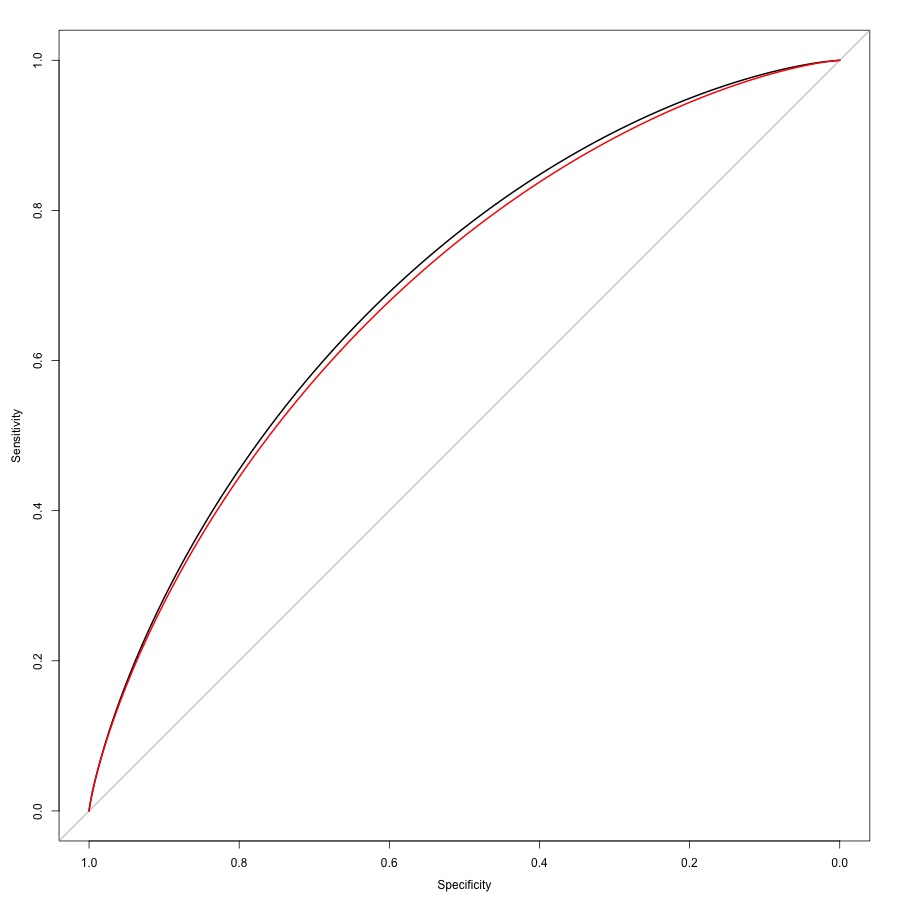

In [9]:
%%R -w 900 -h 900 -u px
wroc <- roc(two_year_recid ~ decile_score, data=w, smooth=TRUE)
broc <- roc(two_year_recid ~ decile_score, data=b, smooth=TRUE)
plot(wroc)
plot(broc, col="red", add=TRUE)